In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import cv2
import os

import numpy as np

In [3]:
IMG_SIZE = 256
BASE_DIR = '../../dataset/'
SAVED_MODEL_DIR = BASE_DIR + '../model'
DATASET_DIR = BASE_DIR + 'Dataset/'

In [4]:
labels = ['with_mask', 'without_mask']
img_size = IMG_SIZE
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
train = get_data(DATASET_DIR)
val = get_data(DATASET_DIR)

<ipython-input-4-b3b8fd16301e>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [6]:
train

array([[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 251, 250],
        [255, 252, 251],
        [255, 254, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 254, 253],
        [255, 254, 253],
        [255, 254, 253]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [182, 178, 177],
        [182, 178, 177],
        [180, 176, 175]],

       ...,

       [[255, 254, 255],
        [255, 254, 255],
        [255, 254, 255],
        ...,
        [ 41,  40,  38],
        [ 41,  40,  38],
        [ 37,  36,  34]],

       [[255, 254, 255],
        [255, 254, 255],
        [255, 254, 255],
        ...,
        [ 43,  42,  40],
        [ 45,  44,  42],
        [ 47,  46,  44]],

       [[255, 254, 255],
        [255, 254, 255],
        [255, 254, 255],
        ...,
        [ 46,  45,  43],
        [ 48,  47,  45],
        [ 56,  5

/Users/davide/Documents/Università/VisionePercezione/mask-detector/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

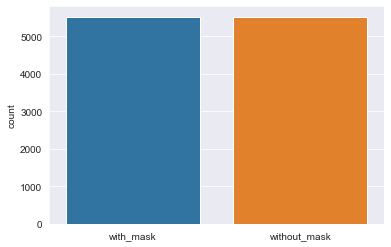

In [7]:
l = []
for i in train:
    if(i[1] == 0):
        l.append(labels[0])
    else:
        l.append(labels[1])
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'with_mask')

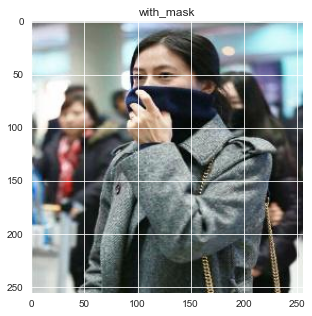

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'without_mask')

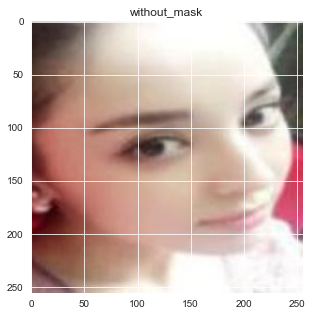

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []
x_val = []
y_val = []

#TODO: vectorize this
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)


In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), 
                                               include_top=False, weights="imagenet")

base_model.trainable = False

model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(2, activation="softmax")])

In [11]:
opt = Adam(learning_rate=0.01)
model.compile(optimizer = opt, 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [12]:
history = model.fit(x_train, y_train, epochs = 1 , validation_data = (x_val, y_val))
model.save(SAVED_MODEL_DIR)

/Users/davide/Documents/Università/VisionePercezione/mask-detector/venv/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


346/346 [==============================] - 1389s 4s/step - loss: 0.0744 - accuracy: 0.9773 - val_loss: 0.0231 - val_accuracy: 0.9928


/Users/davide/Documents/Università/VisionePercezione/mask-detector/venv/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../../dataset/../model/assets


INFO:tensorflow:Assets written to: ../../dataset/../model/assets


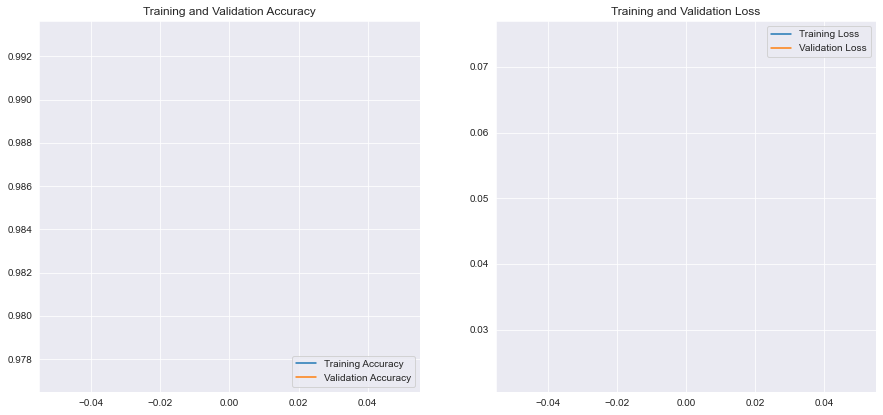

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, 
                            target_names = ['with_mask (Class 0)','without_mask (Class 1)']))

/Users/davide/Documents/Università/VisionePercezione/mask-detector/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                        precision    recall  f1-score   support

   with_mask (Class 0)       1.00      0.99      0.99      5521
without_mask (Class 1)       0.99      1.00      0.99      5521

              accuracy                           0.99     11042
             macro avg       0.99      0.99      0.99     11042
          weighted avg       0.99      0.99      0.99     11042

